### Import libraries

In [1]:
# Import libraries
import fnmatch
import scipy.io as sio
import os
from keras.models import Sequential, Model, load_model
from keras import backend as BK
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sally\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sally\AppData\Roa

### Step.1: define variable and data path

In [2]:
speaker = 's16'
compareGf = 68

model ='s16'

# Step.1: define variable and data path
print('***** Step.1: Define variable and data path *******')
oriSpecPath = 'D:/Mrs_backup/speech_test/AudSpecs/'+speaker+'/'

# get the model input path 
modelInputPath = 'D:/Mrs_backup/speech_test/model_input/gf/'+speaker+'/'

#modelInputPath ='D:/Mrs_backup/speech_test/model_output/GF_100/'+speaker+'_gf/'
autoModelPath = 'D:/Mrs_backup/speech_test/autoencoder/'+speaker+'_trainModel/'

lipModelPath = 'D:/Mrs_backup/speech_test/model_output/gf/'+model+'/'

print('Original spectrogram path is: '+ str(oriSpecPath)+'\n') 
print('Model input path is: '+ str(modelInputPath)+'\n')
print('Autoencoder model path is: '+ str(autoModelPath)+'\n')
print('Main Model path is: '+ str(lipModelPath)+'\n')

evalPath = 'D:/Mrs_backup/speech_test/corr2d/gf/'+model+'/'
#evalPath = 'D:/Mrs_backup/speech_test/corr2d/unseen/gf/'+model+'_to_'+speaker+'/'
if not os.path.exists(evalPath):
    os.mkdir(evalPath )
    
# evalPath = evalPath + speaker+'/'
# if not os.path.exists(evalPath):
#     os.mkdir(evalPath )
print('Result output path is: '+ str(evalPath)+'\n')
print('---------------  End of Step.1  --------------------- ')

***** Step.1: Define variable and data path *******
Original spectrogram path is: D:/Mrs_backup/speech_test/AudSpecs/s16/

Model input path is: D:/Mrs_backup/speech_test/model_input/gf/s16/

Autoencoder model path is: D:/Mrs_backup/speech_test/autoencoder/s16_trainModel/

Main Model path is: D:/Mrs_backup/speech_test/model_output/gf/s16/

Result output path is: D:/Mrs_backup/speech_test/corr2d/gf/s16/

---------------  End of Step.1  --------------------- 


### Step.2: count train and test set

In [3]:
def countTrainAndTest(modelInputPath,numSlices):
    numTrain=len(fnmatch.filter(os.listdir(modelInputPath),'preprocessed_data_final_part*.mat'))
    mat=sio.loadmat(modelInputPath+'preprocessed_data_final_validation.mat')
    print(mat['video_input'].shape)
    numTest = int(mat['video_input'].shape[0]/numSlices)
    return numTrain,numTest


print('***** Step.2: Count train and test set *******')
numSlices=15
numTrain,numTest = countTrainAndTest(modelInputPath,numSlices)
print('Number of training set is: '+ str(numTrain))
print('Number of test set is: '+ str(numTest))
print('---------------  End of Step.2  --------------------- ')

***** Step.2: Count train and test set *******
(300, 26, 21)
Number of training set is: 80
Number of test set is: 20
---------------  End of Step.2  --------------------- 


### Step.3: load data and get input shape

In [4]:
def getOriAudioSize(oriSpecPath):
    filePath = oriSpecPath + os.listdir(oriSpecPath)[0]
    mat=sio.loadmat(filePath)
    audioSize = mat['y'].shape
    return audioSize

# Step.3: load data and get input shape
print('***** Step.3: Count train and test set *******')
audioSize = getOriAudioSize(oriSpecPath)
audioSpecLength = audioSize[0]
audioSpecFreq = audioSize[1]
print('Audio Spectrogram length is: '+ str(audioSpecLength))
print('Audio Spectrogram Freqence is: '+ str(audioSpecFreq))
print('---------------  End of Step.3  --------------------- ')

***** Step.3: Count train and test set *******
Audio Spectrogram length is: 376
Audio Spectrogram Freqence is: 128
---------------  End of Step.3  --------------------- 


### Step.4: load autoencoder and main model

In [5]:
# Define cost function
def corr2_mse_loss(a,b):
    a = BK.tf.subtract(a, BK.tf.reduce_mean(a))
    b = BK.tf.subtract(b, BK.tf.reduce_mean(b))
    tmp1 = BK.tf.reduce_sum(BK.tf.multiply(a,a))
    tmp2 = BK.tf.reduce_sum(BK.tf.multiply(b,b))
    tmp3 = BK.tf.sqrt(BK.tf.multiply(tmp1,tmp2))
    tmp4 = BK.tf.reduce_sum(BK.tf.multiply(a,b))
    r = -BK.tf.divide(tmp4,tmp3)
    m=BK.tf.reduce_mean(BK.tf.square(BK.tf.subtract(a, b)))
    rm=BK.tf.add(r,m)
    return rm

def loadModel(autoModelPath,lipModelPath):
    # Loading AutoEncoder model
    autoModel=load_model(autoModelPath+'autoencoder.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
    autoModel.load_weights(autoModelPath+'autoencoder_weights.h5')
    
    #  Loading LipReading model
    lipModel=load_model(lipModelPath+'model_LipReading.h5',custom_objects={'corr2_mse_loss': corr2_mse_loss})
    #Best weights
    lipModel.load_weights(lipModelPath+'Best_weights_LipReading.h5')
    return autoModel,lipModel


print('***** Step.5: Load autoencoder and main model *******')
autoModel,lipModel = loadModel(autoModelPath,lipModelPath)
print('Autoencoder and lipReading model has loaded.... ')
print('---------------  End of Step.5  --------------------- ')

***** Step.5: Load autoencoder and main model *******
Autoencoder and lipReading model has loaded.... 
---------------  End of Step.5  --------------------- 


### Step.5: load original spectrogram, generate autoencoder spectrogram and predicted spectrogram

In [6]:
def corr2(a,b):
    k = np.shape(a)
    H=k[0]
    W=k[1]
    c = np.zeros((H,W))
    d = np.zeros((H,W))
    e = np.zeros((H,W))

    #Calculating mean values
    AM=np.mean(a)
    BM=np.mean(b)  

    #Calculating terms of the formula
    for ii in range(H):
        for jj in range(W):
            c[ii,jj]=(a[ii,jj]-AM)*(b[ii,jj]-BM)
            d[ii,jj]=(a[ii,jj]-AM)**2
            e[ii,jj]=(b[ii,jj]-BM)**2

    #Formula itself
    r = np.sum(c)/float(np.sqrt(np.sum(d)*np.sum(e)))
    return r

#Define get_activations function
def get_activations(model, layer_in, layer_out, X_batch):
    get_activations = BK.function([model.layers[layer_in].input, BK.learning_phase()], [model.layers[layer_out].output])
    activations = get_activations([X_batch,0])
    return activations

def getPredictedAudio(modelOutput,bottleFeature,sliceLength):
    specOutput=np.reshape(modelOutput,(modelOutput.shape[0],bottleFeature,sliceLength))
    specOutput2=np.concatenate(specOutput,axis=1)
    decodeOutput =get_activations(autoModel, 13, 19, specOutput2.T)[0]
    finalPredictSpec = np.power(decodeOutput,3)
    return finalPredictSpec


def getAutoSpec(oriSpec):
    oriOutput = autoModel.predict(np.power(oriSpec,.3))
    autoSpec = np.power(oriOutput,3)
    return autoSpec

def getAutoSpec2(oriSpec):
    oriOutput = autoModel.predict(np.power(oriSpec,.3))
    autoSpec = np.power(oriOutput,3)
    return autoSpec

def predictSpec(inputFile):
    trainInput = sio.loadmat(inputFile)['video_input']
    modelOutput = lipModel.predict(trainInput) 
    finalPredictSpec = getPredictedAudio(modelOutput,bottleFeature=32,sliceLength=26)
    return finalPredictSpec

def predictSpecTest(testInput):
    modelOutput = lipModel.predict(testInput) 
    finalPredictSpec = getPredictedAudio(modelOutput,bottleFeature=32,sliceLength=26)
    print(finalPredictSpec.shape)
    return finalPredictSpec

In [7]:
trainAutoCorr = np.empty((numTrain), np.dtype('float32'))
trainPreCorr = np.empty((numTrain), np.dtype('float32'))
testAutoCorr = np.empty((numTest), np.dtype('float32'))
testPreCorr = np.empty((numTest), np.dtype('float32'))

print('---------- Load train file -----------------')
trainFile = fnmatch.filter(os.listdir(modelInputPath),'preprocessed_data_final_part*.mat')
trainResult = evalPath+'train/'
if not os.path.exists(trainResult):
    os.mkdir(trainResult )
cor2DTrainPath = evalPath + 'cor2D_train.mat'

print('---------- Load test file -----------------')
testData = sio.loadmat(modelInputPath+'preprocessed_data_final_validation.mat')['video_input']  
testResult = evalPath+'test/'
if not os.path.exists(testResult):
    os.mkdir(testResult)  
cor2DTestPath = evalPath + 'cor2D_test.mat'

---------- Load train file -----------------
---------- Load test file -----------------


In [8]:
print('***** Step.5: load original spectrogram and Generate autoencoder spectrogram *******')  
i=0  
testCount = 0
for count, filename in enumerate(sorted(os.listdir(oriSpecPath)),start=0): 

    # Get the train result
    if count in range(numTrain):
        audioFile  =oriSpecPath+ filename 
        print('Audio File is:' +audioFile)

        # Get original spectrogram
        oriSpec =sio.loadmat(audioFile)['y']
        #print('Original spectrogram shape is:'+ str(oriSpec.shape))
        
        #Get autoencoder spectrogram
#         autoSpec = getAutoSpec(oriSpec)
#         autoCorr = corr2(oriSpec,autoSpec)
#         trainAutoCorr[count] = autoCorr
#         print('Autoencoder spectrogram shape is:'+ str(autoSpec.shape))
#         print('Reconstruted spectrogram from autoencoder with correlation '+str(autoCorr))  

        #Get the predicted spectrogram and save it into train set
        inputFile= modelInputPath+trainFile[count]
        finalPredictSpec = predictSpec(inputFile)
        sio.savemat(trainResult+filename, mdict={'audio_input':finalPredictSpec})
    
        preCorr = corr2(oriSpec,finalPredictSpec)
        trainPreCorr[count] = preCorr
        
        #print('Final predicted spectrogram shape is:'+ str(finalPredictSpec.shape))
        print('Reconstruted spectrogram from lipreading model with correlation '+str(preCorr)+'\n')
        
    else:
        audioFile  =oriSpecPath+ filename 
        print('Audio File is:' +audioFile) 
        
        # Get original spectrogram
        oriSpec =sio.loadmat(audioFile)['y']
        
#         # Get autoencoder spectrogram
#         autoSpec = getAutoSpec(oriSpec)
#         autoCorr = corr2(oriSpec,autoSpec)
#         testAutoCorr[testCount] = autoCorr
        
        # Get the predicted spectrogram and save it into test set
        testInput = testData[i:(i+numSlices),]
        #print(testInput.shape)
        finalPredictSpec = predictSpecTest(testInput)
        sio.savemat(testResult+filename, mdict={'audio_input':finalPredictSpec})
        
        preCorr = corr2(oriSpec,finalPredictSpec)
        testPreCorr[testCount] = preCorr
        
        #print('Final predicted spectrogram shape is:'+ str(finalPredictSpec.shape))
        print('Reconstruted spectrogram from lipreading model with correlation '+str(preCorr)+'\n')
        i=i+numSlices
        testCount=testCount+1
        
sio.savemat(cor2DTrainPath, mdict={'corr2':trainPreCorr})
sio.savemat(cor2DTestPath, mdict={'corr2':testPreCorr})
print('Correclation value from training set has been saved in path: '+ str(cor2DTrainPath))
print('Correclation value from test set has been saved in path: '+ str(cor2DTestPath))
print('Average correlation value from training set is: '+str(np.mean(trainPreCorr)))
print('Average correlation value from test set is: '+str(np.mean(testPreCorr))+'\n')

***** Step.5: load original spectrogram and Generate autoencoder spectrogram *******
Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/000.mat
Reconstruted spectrogram from lipreading model with correlation 0.670082952636542

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/001.mat
Reconstruted spectrogram from lipreading model with correlation 0.79997671795368

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/002.mat
Reconstruted spectrogram from lipreading model with correlation 0.8130479836603407

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/003.mat
Reconstruted spectrogram from lipreading model with correlation 0.7955097166358595

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/004.mat
Reconstruted spectrogram from lipreading model with correlation 0.7447616062002899

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/005.mat
Reconstruted spectrogram from lipreading model with correlation 0.6883877052477609

Audio File is:D:/Mrs_backup/speech_test/AudSpecs

Reconstruted spectrogram from lipreading model with correlation 0.8221909375931971

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/057.mat
Reconstruted spectrogram from lipreading model with correlation 0.7415445501996359

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/058.mat
Reconstruted spectrogram from lipreading model with correlation 0.7193672580922048

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/059.mat
Reconstruted spectrogram from lipreading model with correlation 0.6830164351164929

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/060.mat
Reconstruted spectrogram from lipreading model with correlation 0.8449249270489093

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/061.mat
Reconstruted spectrogram from lipreading model with correlation 0.8365351623743895

Audio File is:D:/Mrs_backup/speech_test/AudSpecs/s16/062.mat
Reconstruted spectrogram from lipreading model with correlation 0.7996738026192844

Audio File is:D:/Mrs_backup/speech_test/AudSpe

### Step 6:  Result analysis

In [9]:
def removeOutliers(corrData):
    # calculate summary statistics
    data_mean, data_std = mean(corrData), std(corrData)
    #print('Original data mean is '+ str(data_mean))

    # identify outliers
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    # identify outliers
    outliers = [x for x in corrData if x < lower or x > upper]
    #print('Identified outliers: %d' % len(outliers)+ ', which is '+str(outliers))

    # remove outliers
    outliers_removed = [x for x in corrData if x >= lower and x <= upper]
    #print('Non-outlier observations: %d' % len(outliers_removed))
    print(outliers_removed)
    
    avgCorr = np.mean(outliers_removed)
    
    return avgCorr

In [10]:
maxCorr = evalPath+'maxCorr/'
if not os.path.exists(maxCorr):
    os.mkdir(maxCorr )

### Training set result analysis

In [11]:
print(trainPreCorr)
stdAvgTrain = np.mean(trainPreCorr)
print('Average correlation value from training set is: '+str(stdAvgTrain))
stdAvgTrain = removeOutliers(trainPreCorr)
#stdAvgTrain = np.mean(trainPreCorr)
print('Average correlation value from training set is: '+str(stdAvgTrain))

[0.6700829  0.7999767  0.813048   0.7955097  0.7447616  0.6883877
 0.71936    0.7805618  0.81872565 0.83161306 0.7760292  0.80069864
 0.72800976 0.84412456 0.716163   0.72648937 0.78535783 0.8110784
 0.782212   0.8281419  0.5457176  0.70504296 0.82593685 0.692078
 0.7821048  0.70513225 0.67457086 0.6440693  0.745506   0.75025684
 0.82090384 0.8132342  0.36325428 0.74395096 0.8473277  0.612989
 0.69639194 0.806602   0.720837   0.81750995 0.83743197 0.82019
 0.78669345 0.5842997  0.79760027 0.7480896  0.67995524 0.62467074
 0.8093586  0.7147038  0.85954106 0.8328884  0.8563219  0.80281866
 0.8611751  0.8291492  0.82219094 0.74154454 0.71936727 0.6830164
 0.8449249  0.83653516 0.7996738  0.7779289  0.7647269  0.8634501
 0.7982184  0.8002382  0.8799426  0.86463034 0.84581816 0.80927056
 0.8609846  0.79689586 0.8008144  0.84987205 0.83986425 0.8590397
 0.7693216  0.83253014]
Average correlation value from training set is: 0.77099293
[0.6700829, 0.7999767, 0.813048, 0.7955097, 0.7447616, 0.6

In [12]:
(maxCorrtTrain,maxIndexTrain) = max((v,i) for i,v in enumerate(trainPreCorr))
print ('Maxmum correlation value from training set is: '+str(maxCorrtTrain)+' on video: '+str(maxIndexTrain))

Maxmum correlation value from training set is: 0.8799426 on video: 68


In [13]:
maxCorrTrain = maxCorr+'train/'
if not os.path.exists(maxCorrTrain):
    os.mkdir(maxCorrTrain )

(376, 128)
D:/Mrs_backup/speech_test/corr2d/gf/s16/train/068.mat
(390, 128)


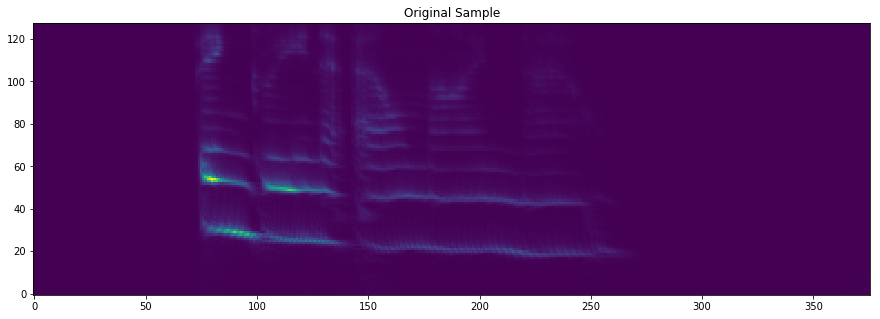

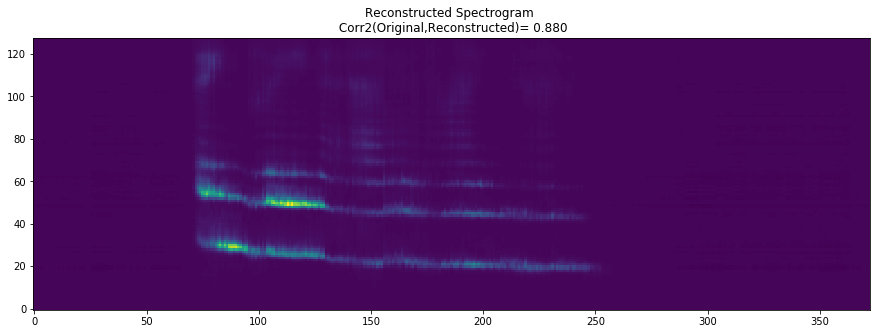

In [14]:
# Plot maxmum spectrogram from train set and save the output

# Load maxOri spectrogram
maxNum="{number:03}".format(number=(maxIndexTrain))

maxOriPath = oriSpecPath+ maxNum+'.mat'
MaxOriSpec =sio.loadmat(maxOriPath)['y']
print(MaxOriSpec.shape)
sio.savemat(maxCorrTrain+maxNum+'_ori.mat', mdict={'audio_input':MaxOriSpec})

figure1 = plt.figure(1,figsize=(15, 5))
plt.title('Original Sample')
plt.imshow(MaxOriSpec.T, origin="lower", aspect="auto", interpolation="none")
figure1.savefig(maxCorrTrain+maxNum+'_Original spectrogram.png', dpi=figure1.dpi)

# Load maxPre spectrogram
maxPrePath = trainResult+ maxNum+'.mat'
print(maxPrePath)
MaxPreSpec =sio.loadmat(maxPrePath)['audio_input']
print(MaxPreSpec.shape)
sio.savemat(maxCorrTrain+maxNum+'_pre.mat', mdict={'audio_input':MaxPreSpec})

# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(15, 5))
plt.imshow(MaxPreSpec[0:373,].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed Spectrogram \n Corr2(Original,Reconstructed)= %.3f'%corr2(MaxOriSpec[0:373,],MaxPreSpec[0:373,]))
figure2.savefig(maxCorrTrain+maxNum+'_Reconstruted spectrogram.png', dpi=figure1.dpi)

(376, 128)
D:/Mrs_backup/speech_test/corr2d/gf/s16/train/068.mat
(390, 128)


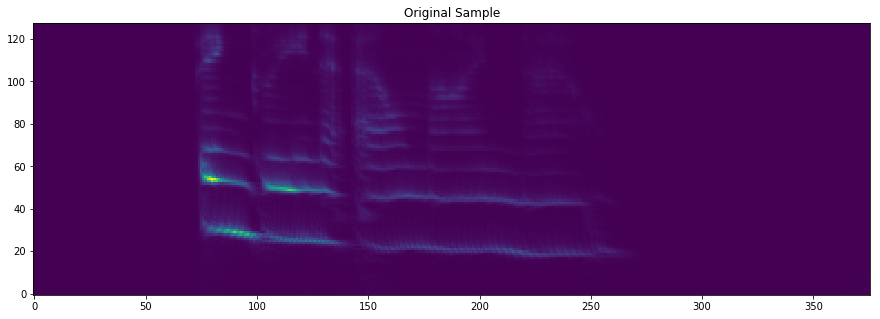

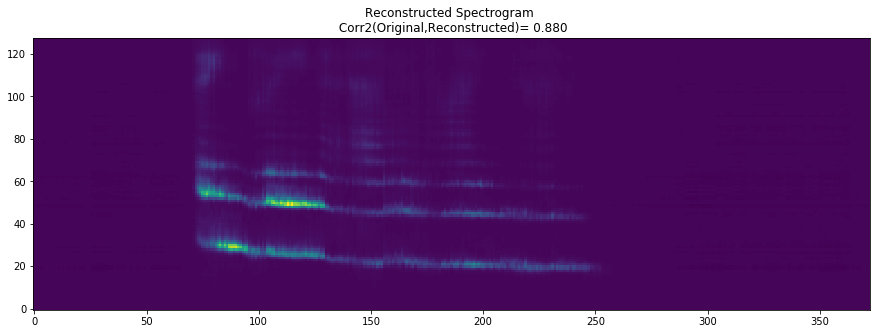

In [15]:
# Plot maxmum spectrogram from train set and save the output
# Load maxOri spectrogram
#maxNum="{number:03}".format(number=(maxIndexTrain))
maxNum="{number:03}".format(number=(compareGf))

maxOriPath = oriSpecPath+ maxNum+'.mat'
MaxOriSpec =sio.loadmat(maxOriPath)['y']
print(MaxOriSpec.shape)
sio.savemat(maxCorrTrain+maxNum+'_ori.mat', mdict={'audio_input':MaxOriSpec})

figure1 = plt.figure(1,figsize=(15, 5))
plt.title('Original Sample')
plt.imshow(MaxOriSpec.T, origin="lower", aspect="auto", interpolation="none")
figure1.savefig(maxCorrTrain+maxNum+'_Original spectrogram.png', dpi=figure1.dpi)

# Load maxPre spectrogram
maxPrePath = trainResult+ maxNum+'.mat'
print(maxPrePath)
MaxPreSpec =sio.loadmat(maxPrePath)['audio_input']
print(MaxPreSpec.shape)
sio.savemat(maxCorrTrain+maxNum+'_pre.mat', mdict={'audio_input':MaxPreSpec})

# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(15, 5))
plt.imshow(MaxPreSpec[0:373,].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed Spectrogram \n Corr2(Original,Reconstructed)= %.3f'%corr2(MaxOriSpec[0:373,],MaxPreSpec[0:373,]))
figure2.savefig(maxCorrTrain+maxNum+'_Reconstruted spectrogram.png', dpi=figure1.dpi)

### Test set result analysis

In [16]:
print(testPreCorr)
print('Average correlation value from training set is: '+str(np.mean(testPreCorr)))
stdAvgTest = removeOutliers(testPreCorr)
print('Average correlation value from training set is: '+str(stdAvgTest))

[0.46588838 0.3600741  0.43896252 0.47830862 0.20229423 0.6028739
 0.48372847 0.48931417 0.3017723  0.4317492  0.2505729  0.5477866
 0.07579911 0.5127599  0.3123675  0.39862058 0.63531625 0.4038683
 0.54694414 0.5290063 ]
Average correlation value from training set is: 0.42340034
[0.46588838, 0.3600741, 0.43896252, 0.47830862, 0.20229423, 0.6028739, 0.48372847, 0.48931417, 0.3017723, 0.4317492, 0.2505729, 0.5477866, 0.5127599, 0.3123675, 0.39862058, 0.63531625, 0.4038683, 0.54694414, 0.5290063]
Average correlation value from training set is: 0.44169515


In [17]:
(maxCorrtTest,maxIndexTest) = max((v,i) for i,v in enumerate(testPreCorr))
print ('Maxmum correlation value from test set is: '+str(maxCorrtTest)+' on video: '+str(maxIndexTest))

Maxmum correlation value from test set is: 0.63531625 on video: 16


In [18]:
maxCorrTest = maxCorr+'test/'
if not os.path.exists(maxCorrTest):
    os.mkdir(maxCorrTest )

D:/Mrs_backup/speech_test/AudSpecs/s16/096.mat
(376, 128)
D:/Mrs_backup/speech_test/corr2d/gf/s16/test/096.mat
(390, 128)


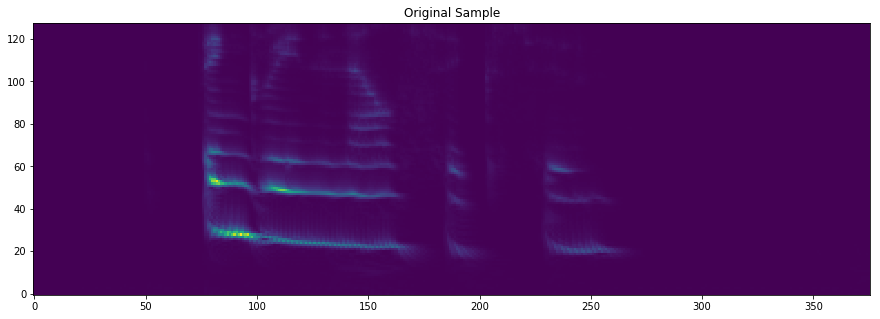

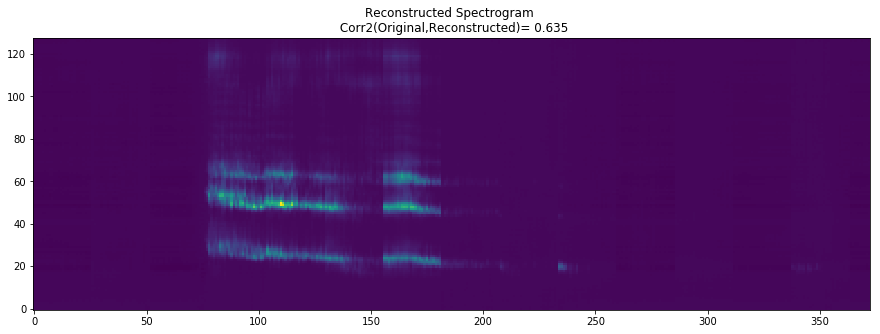

In [19]:
# Load maxOri spectrogram
maxNum="{number:03}".format(number=(maxIndexTest+numTrain))
maxOriPath = oriSpecPath+ maxNum+'.mat'
print(maxOriPath)
MaxOriSpec =sio.loadmat(maxOriPath)['y']
print(MaxOriSpec.shape)
sio.savemat(maxCorrTest+maxNum+'_ori.mat', mdict={'audio_input':MaxOriSpec})

figure1 = plt.figure(1,figsize=(15, 5))
plt.title('Original Sample')
plt.imshow(MaxOriSpec.T, origin="lower", aspect="auto", interpolation="none")
figure1.savefig(maxCorrTest+maxNum+'_Original spectrogram.png', dpi=figure1.dpi)

# Load maxPre spectrogram
maxPrePath = testResult+ maxNum+'.mat'
print(maxPrePath)
MaxPreSpec =sio.loadmat(maxPrePath)['audio_input']
print(MaxPreSpec.shape)
sio.savemat(maxCorrTest+maxNum+'_pre.mat', mdict={'audio_input':MaxPreSpec})

# Plot Reconstruted spectrogram after reserving the compression process
figure2 = plt.figure(2,figsize=(15, 5))
plt.imshow(MaxPreSpec[0:373,].T, origin="lower", aspect="auto", interpolation="none")
plt.title('Reconstructed Spectrogram \n Corr2(Original,Reconstructed)= %.3f'%corr2(MaxOriSpec[0:373,],MaxPreSpec[0:373,]))
figure2.savefig(maxCorrTest+maxNum+'_Reconstruted spectrogram.png', dpi=figure1.dpi)

### Save avg and max value from training and test set

In [20]:
sio.savemat(evalPath+'/corr2D.mat', mdict={'train_avg':stdAvgTrain,
                                           'train_max':maxCorrtTrain,
                                           'train_index':maxIndexTrain,
                                           'test_avg':stdAvgTest, 
                                           'test_max':maxCorrtTest,
                                           'test_index':maxIndexTest})